In [1]:
import sys
sys.version

'3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('dataset/cleaned.csv')

In [4]:
df

,E,pt,eta,phi
0,1069460.0,751597.0,0.858186,-1.842170
1,457647.0,110079.0,2.102870,2.175010
2,49649.1,30875.2,-1.031890,-1.799200
3,676000.0,640429.0,0.330450,0.704554
4,1239300.0,602104.0,1.343240,-0.550856
...,...,...,...,...
20360,731849.0,722541.0,-0.134499,2.563930
20361,268828.0,259144.0,0.153813,0.578428
20362,153340.0,43931.5,1.920140,-0.237382
20363,893689.0,742040.0,-0.618057,-3.104660


In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

In [7]:
df_normalized = df.copy()
df_normalized[df_normalized.columns] = StandardScaler().fit_transform(df_normalized)

In [8]:
# shuffling the data before splitting
df_normalized = shuffle(df_normalized)

# split the data into train and test with a ratio of 20%
train_x, test_x = train_test_split(df_normalized, test_size=0.2, random_state=1)

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(16292, 4)
Test data shape: 
(4073, 4)


In [9]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [12]:
class AE_Custom_Arch(nn.Module):
    def __init__(self, n_features=4, leakyRelu: bool = False):
        super(AE_Custom_Arch, self).__init__()
        self.en1 = nn.Linear(n_features, 128)
        self.en2 = nn.Linear(128, 64)
        self.en3 = nn.Linear(64, 32)
        self.en4 = nn.Linear(32, 3)
        self.de1 = nn.Linear(3, 32)
        self.de2 = nn.Linear(32, 64)
        self.de3 = nn.Linear(64, 128)
        self.de4 = nn.Linear(128, n_features)
        self.relu = leakyRelu
        if self.relu:
            self.leakyRelu = nn.LeakyReLU()
        else:
            self.tanh = nn.Tanh()
        
    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [13]:
model = AE_Custom_Arch()
model.to('cpu')

AE_Custom_Arch(
  (en1): Linear(in_features=4, out_features=128, bias=True)
  (en2): Linear(in_features=128, out_features=64, bias=True)
  (en3): Linear(in_features=64, out_features=32, bias=True)
  (en4): Linear(in_features=32, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=32, bias=True)
  (de2): Linear(in_features=32, out_features=64, bias=True)
  (de3): Linear(in_features=64, out_features=128, bias=True)
  (de4): Linear(in_features=128, out_features=4, bias=True)
  (tanh): Tanh()
)

In [14]:
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)

Learning rate with the minimum loss: 0.00831763744354248
Learning rate with the steepest gradient: 0.009120108559727669


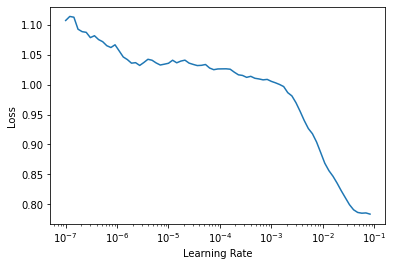

In [15]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [16]:
import time

start = time.perf_counter() # Starts timer
# train our autoencoder for 100 epochs
learn.fit_one_cycle(100, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.620793,0.367073,00:00
0,0.620793,0.367073,00:00
1,0.299677,0.142399,00:00
1,0.299677,0.142399,00:00
2,0.164354,0.086509,00:00
2,0.164354,0.086509,00:00
3,0.103296,0.067805,00:01
3,0.103296,0.067805,00:01
4,0.077682,0.051962,00:00
4,0.077682,0.051962,00:00


Training took 98.40050930000001 seconds


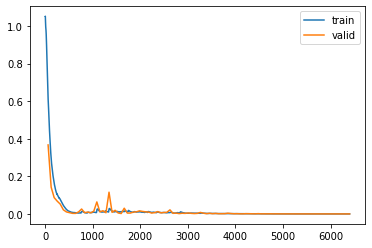

In [17]:
recorder.plot_loss()

In [18]:
learn.validate()

(#1) [5.1005601562792435e-05]

In [20]:
import os
save_dir = "plots\AE_Custom_Arch\Tanh"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

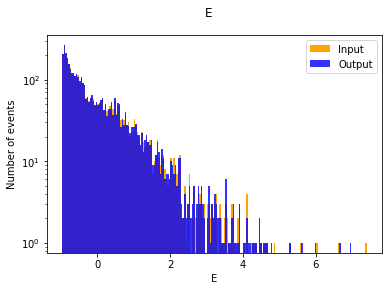

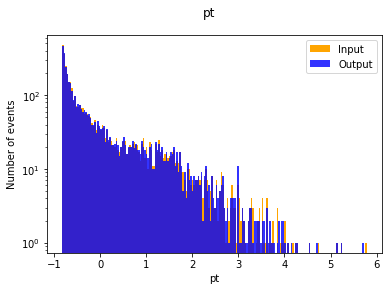

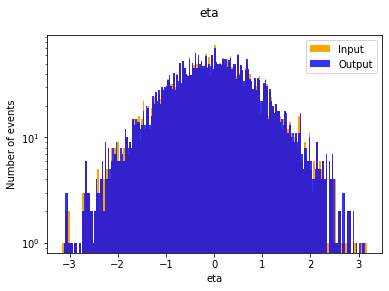

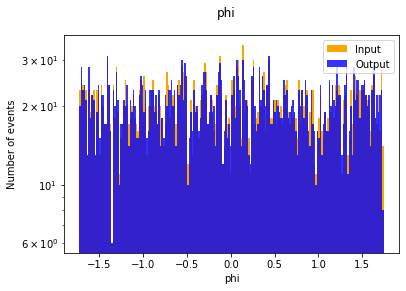

In [22]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['blue', 'orange']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test_x.columns)
pred_df = pd.DataFrame(pred, columns=test_x.columns)

alph = 0.8
n_bins = 200

for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test_x.columns[kk])
    plt.xlabel(test_x.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test_x.columns[kk]+'.png'))
    plt.legend()